# Cell Death Simulation

## Introduction

The aim of this simulation is to showcase that radiation with different LET (Linear Energy Transfer) values create different cell survival curves depending on the absorbed dose. Here I present two different radiations. 

**Gamma radiation**: Photons upon entering the cell nucleus sufferes several scattering events resulting in a distributions of DNA strand breaks resembling that of a *Uniform distribution*.

**Alpha radiation**: Alpha particles are quite heavy and therefore dose not scatter within the cell nucleus, but deposit their energy, and therefore create DNA strand breaks, along their line of flight.

Below you may find the libraries, functions and their explonation and the results of the simulation.

## Libraries

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from functools import reduce
#%matplotlib widget 

## Functions of the simulation

In [2]:
def RandomPointInSphere(radius):
    "Algorithm that creates a random point in a spehere with given radius"
    # Generate random spherical coordinates
    theta = np.random.uniform(0, np.pi)   # Azimuthal angle
    phi = np.random.uniform(0, 2*np.pi)   # Polar angle
    r = radius * np.sqrt(np.random.uniform(0, 1))   # distance from origin

    # Convert to Cartesian coordinates:

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def RandomPointsOnSphere(radius):
    "Algorithm that creates a random point within a sphere with given radius "
    # Generate random spherical coordinates for the first point
    theta1 = np.random.uniform(0, np.pi)  # Azimuthal angle
    phi1 = np.random.uniform(0, 2 * np.pi)  # Polar angle

    # Convert spherical coordinates to Cartesian coordinates
    x1 = radius * np.sin(theta1) * np.cos(phi1)
    y1 = radius * np.sin(theta1) * np.sin(phi1)
    z1 = radius * np.cos(theta1)

    # Generate random spherical coordinates for the second point
    theta2 = np.random.uniform(0, np.pi)  # Azimuthal angle
    phi2 = np.random.uniform(0, 2 * np.pi)  # Polar angle

    # Convert spherical coordinates to Cartesian coordinates
    x2 = radius * np.sin(theta2) * np.cos(phi2)
    y2 = radius * np.sin(theta2) * np.sin(phi2)
    z2 = radius * np.cos(theta2)

    return [x1, y1, z1], [x2, y2, z2]

def MultiplyElements(list):
    "Simple algoritm that multiplies all element together in a list"
    if len(list) == 0:
        return(1)
    else:
        return reduce(lambda x, y: x * y, list)
    
def GetPointOnLine(point_start, point_end, distance):
    "Alogrithm that generates the coordinates of a point along the line using the orgin and end point and the distance from the origin point"
    # Normalized Direction vector of the line
    direction_vector = np.array(point_end) - np.array(point_start)
    direction_unit_vector = direction_vector / np.linalg.norm(direction_vector)
    
    # Calculate the coordinates of the strand break
    strand_break_coordinate = np.array(point_start) + distance * direction_unit_vector

    return strand_break_coordinate

def PhotonStrandBreakLocations(cell_radius, dose):
    "Algorithm that simulates DNA strand breaks in the cell nucleus caused by gamma radiation"
    coordinates = []
    for i in range(0, int(dose * 40)): # it is 40 times the dose because an average of 1 Gy dose creates 40 double strand breaks.
        x, y, z = RandomPointInSphere(cell_radius)
        coordinates.append([x,y,z])

    return coordinates

def AlphaParticleLineBreaks(cell_radius, dose):
    "Algorithm that simulates DNA strand breaks in the cell nucleus caused by alpha radiation"
    # Parameters 
    LIN = 166 # keV/micrometer of a 2.5 MeV alpha particle

    # Calculations of the number of breaks produced by the alpha radiation
    Absorbed_energy = dose * 6.242 * 10**3 
    number_of_breaks = int(Absorbed_energy / LIN)

    # List containing the distance of the strand break from the origin point along the lines
    breaks_on_lines = []

    # Miscellaneous parameters for the calculatin
    lenght_used = 0
    break_count = 0
    temp_break_list = []

    # Creating the line along 
    c1, c2 = RandomPointsOnSphere(cell_radius)
    line_lenght = math.dist(c1,c2)

    line_coordinates = [[c1, c2]]

    while number_of_breaks != break_count:

        line_break = np.abs(np.random.normal(1, 1))
        lenght_used = lenght_used + line_break
        if lenght_used < line_lenght:
            temp_break_list.append(lenght_used)
            if lenght_used > 2*cell_radius:
                print("Something wrong")
            break_count += 1
        else:
            breaks_on_lines.append(temp_break_list)
            lenght_used = 0
            temp_break_list = []
            c11, c22 = RandomPointsOnSphere(cell_radius)
            line_lenght = math.dist(c11,c22)
            line_coordinates.append([c11,c22])

    if number_of_breaks == break_count:
        breaks_on_lines.append(temp_break_list)

    return line_coordinates, breaks_on_lines

def AlphaStrandBreakLocations(cell_radius, dose):
    "Algorthm that calculates the coordinates of strand breaks caused by alpha particle radiation"
    
    # Creating the lines along witch the alpha particles travel and the strand break distances from the entry point of the particle
    line_coordinates, strand_break_distances = AlphaParticleLineBreaks(cell_radius, dose)

    # List containing the coordinates of the strand breaks
    coordinates = []
    line_origin = []

    # Calculating the coordinates of the strand break
    for index, line in enumerate(line_coordinates):
        strand_break_distances_of_given_line = strand_break_distances[index]
        line_origin.append(line)
        for strand_break_distance in strand_break_distances_of_given_line:
            strand_break_coordinates = GetPointOnLine(line[0], line[1], strand_break_distance)
            coordinates.append(strand_break_coordinates)

    return coordinates


def StrandBreakDistances(coordinates = list):
    "Algorthm that calculates the distance between strand breaks"
    distances = []
    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            if j != i:
                distances.append(math.dist(coordinates[i], coordinates[j]))

    return distances


def CellSurvival(distances):
    "Algorithm that decides whether a cell survives the interaction of two strand breaks"
    state = "dead"
    
    interaction_survival_probabilities = []
    
    for distance in distances:
        interaction_survival_probabilities.append(1 - np.exp(-distance*5))

    cell_survival_probability = MultiplyElements(interaction_survival_probabilities)

    random_number = np.random.uniform(0,1)

    if random_number < cell_survival_probability:
        state = "alive"

    return state
    

def CellDeathSimulation(cell_number, cell_radius, dose, mode):
    "Algorithm that runs the cell survival simulation. There are two different modes: photon or alpha, which decides which type of radiation the algorithm simulates."
    # Number of surviving cells
    survivors = 0
    
    # Running the Simulation for the given number of cells
    for i in range(cell_number):
    
        # Calculating the number of strand break within the depending on the type of ionzing radiation
        if mode == "photon":
            coordinates = PhotonStrandBreakLocations(cell_radius, dose)
        elif mode == "alpha":
            coordinates = AlphaStrandBreakLocations(cell_radius, dose)
        else:
            raise Exception("Invalid mode")
        
        # Calculating the distance between the strand breaks
        distances = StrandBreakDistances(coordinates)

        # Calculating the probability that the cell survives the double strand breaks
        cell_status = CellSurvival(distances)

        if cell_status == "alive":
            survivors += 1

    
    return survivors/cell_number

# Algorthm for displaying:

def CoordinateSeparator(point_array):
    "Auxiliary algorthm for AlphaStrandBreakLocations to separate all the x, y, z coordinates"
    
    # Extract x, y, z coordinates from the array
    x_coords = np.array([point[0] for point in point_array])
    y_coords = np.array([point[1] for point in point_array])
    z_coords = np.array([point[2] for point in point_array])

    return x_coords, y_coords, z_coords

def SphereDrawing(radius):
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:10j, 0:np.pi:10j]
    x = radius * np.cos(u)*np.sin(v)
    y = radius * np.sin(u)*np.sin(v)
    z = radius * np.cos(v)

    return x, y, z

def average_columns(matrix):
    num_rows = len(matrix)
    num_cols = len(matrix[0]) if num_rows > 0 else 0

    # Initialize list to store column sums
    column_sums = [0] * num_cols

    # Calculate column sums
    for row in matrix:
        for j in range(num_cols):
            column_sums[j] += row[j]

    # Calculate column averages
    column_averages = [sum / num_rows for sum in column_sums]

    return column_averages

# Explanation of the alogirhms

Here you can find a explanation of how the alogrithms work and what considerations were made for the simulation. The whole process is contained in the **CellDeathSimulation** algorthm in which we can give the following parameters:
- cell_number: the number of cells participating in the simualtion
- cell_radius: the radius of the cell nucleus
- dose: The dose absorbed by the cell nucleus
- mode: Either "photon" or "alpha", which decides the type of radiation creating the strand breaks in the DNA

For the Purposes of the explonation below you can see the parameters:

In [3]:
# Explonation parameters
number_of_cells = 100 # The amount of cell the simualtion will be run for
radius_of_cells = 6 # The radius of the cell nucleus in micro-meters
dose = 1 # The dose given to the cell nucleus in Gy

## Simulating the DNA strand breaks

### Gamma particles
As stated above gamma particles suffer several scattering events during their travel within the cell nucleus. Therefore, the distribution of the strand breaks will resemble, that of a uniform distribution. Therefore what happens is that using the *dose and cell_radius parameters* the algorithm creates 40 times as many strand breaks uniformaly distributed within the cell nucleus. Used algorithms:
- **PhotonStrandBreakLocations**: 
    - Unformaly samples a sphere (cell nucleus) of given radius

### Alpha particles
As alpha particles distribute there energy along the line of their flight the creating of the strand break locations is a bit more difficulat. The following considerations were used:
- The $\alpha$ particle is assumed to be of energy $2.5$ MeV, which has a LIN of 166 keV/$\mu m$
- The mass of the cell nucleus is assumed to be $1\times10^{-12} kg$
To get how many strand breaks are caused by the dose we have to convert the Gy = J/kg to eV, which after calucalations gives us that a nucleus absorbes from $1$ Gy of alpha radiation around $6.242\cdot 10^{3}$ keV energy. Assuming that $166$ keV energy creates one break we get that the number of breaks created is $$\text{line breaks} = \frac{\text{Absorbed Energy}}{\text{LIN}}$$

The following alogrithm and its sub-algorithms than create the coordintaes of the strand breaks:
- **AlphaStrandBreakLocations**: 
    - **AlphaParticleLineBreaks**: 
        - Samples random two point on a surface of a sphere, which will be the line of flight of the alpha particle.
        - Creates the distances of the strand breaks along the line from one of the points using uniform distribution with a expeced value  of $1$ (as for every 166 keV deposited energy the alpha particle travels around 1 $\mu m$) and variance of $1$.
        - If the end of the line is reached a but there is still strand breaks to place a new line is created.
    - **GetPointOnLine**:
        - Creates the coordinates of the strand breaks using their distance from the line origin point

**Below are the results of the two algorithm**

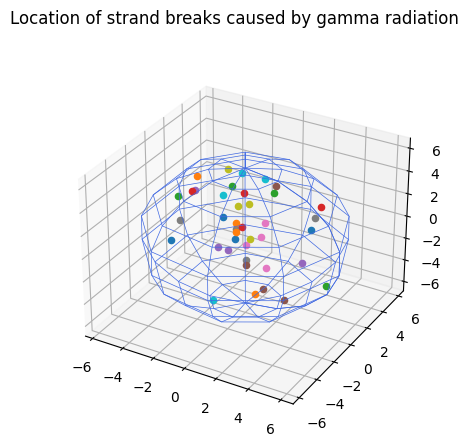

In [4]:
#%matplotlib qt
# Simulating the strand breaks caused by the gamma radiation
gamma_sb_coordinates = PhotonStrandBreakLocations(radius_of_cells, dose)

# Displaing the results
x,y,z = SphereDrawing(radius_of_cells)
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(x, y, z, color="royalblue", lw = 0.5)
fig.suptitle("Location of strand breaks caused by gamma radiation")
for coordinate in gamma_sb_coordinates:
    ax1.scatter(coordinate[0], coordinate[1], coordinate[2])

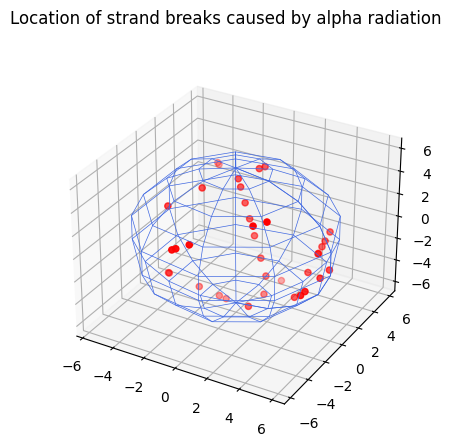

In [5]:
# Simulating the strand breaks caused by the alpha radiation
alpha_sb_coordinates= AlphaStrandBreakLocations(radius_of_cells, dose)
alpha_x, alpha_y, alpha_z = CoordinateSeparator(alpha_sb_coordinates)

# Displaing the results
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot_wireframe(x, y, z, color="royalblue", lw = 0.5)
fig.suptitle("Location of strand breaks caused by alpha radiation")
ax2.scatter(alpha_x, alpha_y, alpha_z, color = "red")

## Deciding whether the cell dies or survives

As the location of the strand breaks are calculated the rest of the simulation is quite straight forward:
- Using the coordinates of the break we calculate their distances from each other (**StrandBreakDistances**)
- We decide if a cell survives with the **CellSurvival** algorithm. Assumptions:
    - The probability of survival is dependent on the distance of two strand breaks, described by a monoton descending function:$$f(\text{distance}) = 1 - \exp(-\beta\cdot\text{distance})$$
    - The probabilities of survival are independent of each other

**Below we can see two shorth simulations and their results**

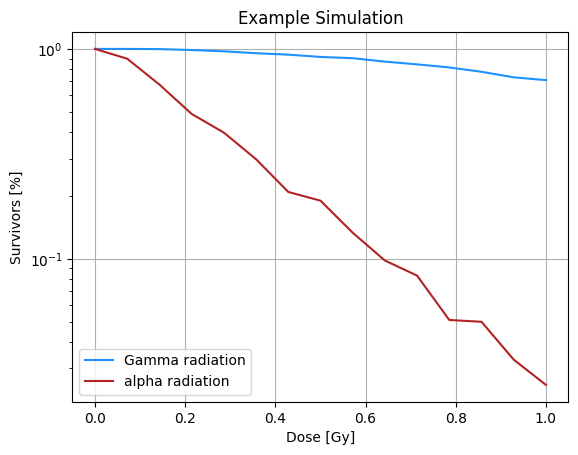

In [6]:
%matplotlib inline 
gamma_doses = np.linspace(0,1,15)
gamma_survivors = []
for dose in gamma_doses:
    gamma_survivors.append(CellDeathSimulation(1000, 6, dose, "photon"))

alpha_doses = np.linspace(0,1,15)
alpha_survivors = []
for dose in alpha_doses:
    alpha_survivors.append(CellDeathSimulation(1000, 6, dose, "alpha"))

# Displaying
fig = plt.figure(figsize=(12,4))
plt.plot(gamma_doses, gamma_survivors, label = "Gamma radiation", color = "dodgerblue")
plt.plot(alpha_doses, alpha_survivors, label = "alpha radiation", color = "firebrick")
plt.title("Example Simulation")
plt.xlabel("Dose [Gy]")
plt.ylabel("Survivors [%]")
plt.grid()
plt.legend()
plt.yscale("log")

# Simulation
Here we run the simulation 10 times for each type of radiation between $0$ Gy and $5$ Gy and display the average percentage of survivals

In [7]:
gamma_survivors = []
alpha_survivors = []

# Running the simulation 10 times
for i in range(0, 10):
    gamma_doses = np.linspace(0,4,15)
    temp_gamma_survivors = []
    for dose in gamma_doses:
        temp_gamma_survivors.append(CellDeathSimulation(1000, 6, dose, "photon"))
    gamma_survivors.append(temp_gamma_survivors)

    alpha_doses = np.linspace(0,2,15)
    temp_alpha_survivors = []
    for dose in alpha_doses:
        temp_alpha_survivors.append(CellDeathSimulation(1000, 6, dose, "alpha"))
    alpha_survivors.append(temp_alpha_survivors)

# Averaging the results
gamma_survivors_average =  average_columns(gamma_survivors)
alpha_survivors_average =  average_columns(alpha_survivors)

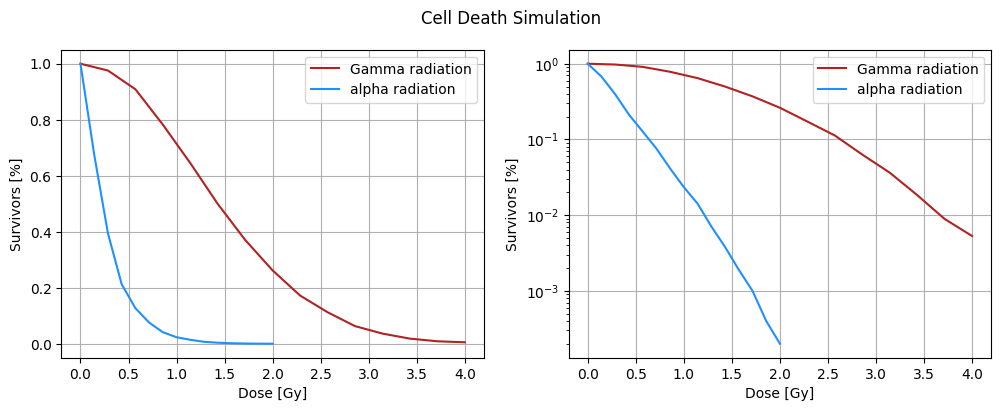

In [11]:
# Displaying
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(gamma_doses, gamma_survivors_average, label = "Gamma radiation", color = "firebrick")
ax1.plot(alpha_doses, alpha_survivors_average, label = "alpha radiation", color = "dodgerblue")
ax1.set(xlabel='Dose [Gy]', ylabel='Survivors [%]')
fig.suptitle('Cell Death Simulation')
ax1.grid()
ax1.legend()

ax2.plot(gamma_doses, gamma_survivors_average, label = "Gamma radiation", color = "firebrick")
ax2.plot(alpha_doses, alpha_survivors_average, label = "alpha radiation", color = "dodgerblue")
ax2.set(xlabel='Dose [Gy]', ylabel='Survivors [%]')
ax2.grid()
ax2.legend()
ax2.set_yscale("log")
